# Deep Learning First Individual Assignment | Predicting Abalone Age

## Project Evaluation Criteria

### Data Loading and Preprocessing (2 points max)
- Load the data from the CSV files using the appropriate data import methods in PyTorch.
- Apply dataset splits that enable you to assess network overfitting.
- Preprocess the categorical and numerical data accordingly (refer to **Lesson 5 – Training Practices and Regularization** and **Lesson 6 – PyTorch in Production**).
- Make data loading protocols for mini-batch training.

### Approach and Methodology (2 points max)
- Implement a neural network architecture suited to the task and justify your choice (refer to **Lesson 6 – PyTorch in Production**).
- Apply regularization techniques that help prevent network overfitting.

### Results and Evaluation (2 points max)
- Build a training protocol to train your neural network on the dataset with a user-specified number of epochs.
- Implement methods that effectively regulate the training process (refer to **Lab 5 – Training Practices and Regularization**).
- Provide visualizations, if useful, that give an indication of the training procedure (e.g., a loss curve). These visualizations can be included in your report as part of your submission package.
- Implement a software method that saves the network’s weight with the best performance.  
  - These network weights should be saved as `.pt` / `.pth` file.
  - Include them as part of your submission package so that the teacher and the teaching assistant can reproduce your results. 

### Code Quality and Reproducibility (2 points max)
- Your code should be clean, well-structured, and properly commented.
- Ensure the code runs in inference mode with your network weights (`.pt` / `.pth` file) to produce the target variable (the number of rings) using the data from `test.csv`.
- Ensure that the model generates predictions for the number of rings for every data point in the test set.
- Write a `README` file for running your code in inference mode to produce the targets.  
  - This will help the teacher and the teaching assistant reproduce your results. 

### Summary and Justification (2 points max)
- Clearly summarize the key novelties of your approach.
- Justify the choices made in the data preprocessing, neural network design, training protocol, and inference protocol.
- Discuss any challenges encountered and potential improvements.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

SKIP_TRAINING = False

device, device_name = (torch.device("cuda"), torch.cuda.get_device_name(0)) if torch.cuda.is_available() else (torch.device("cpu"), "CPU")
print(f"Device: {device}, {device_name}")

Device: cpu, CPU


In [2]:
def set_seed(seed=42):
    torch.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)      
    np.random.seed(seed)                  
    random.seed(seed)                     
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False     

set_seed(42)

In [3]:
train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

In [4]:
class AbaloneDataset(Dataset):
    def __init__(self, csv_path, is_test=False, mean=None, std=None):
        self.data = pd.read_csv(csv_path)
        self.is_test = is_test

        # Define columns
        self.numeric_cols = [
            'Length', 'Diameter', 'Height', 'Whole_weight',
            'Shucked_weight', 'Viscera_weight', 'Shell_weight'
        ]
        self.sex_mapping = {'M': 0, 'F': 1, 'I': 2}

        # Compute or load mean and std for standardization
        if not is_test:
            self.mean = torch.tensor(self.data[self.numeric_cols].mean().values, dtype=torch.float32) 
            self.std = torch.tensor(self.data[self.numeric_cols].std().values, dtype=torch.float32)
        else:
            self.mean = mean.clone().detach()
            self.std = std.clone().detach()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # One-hot encode 'Sex'
        sex_index = self.sex_mapping[row['Sex']]
        sex_one_hot = torch.nn.functional.one_hot(torch.tensor(sex_index), num_classes=3).float()

        # Get numeric features and standardize
        numeric = torch.tensor([row[col] for col in self.numeric_cols], dtype=torch.float32)
        numeric = (numeric - self.mean) / self.std

        # Combine features
        features = torch.cat([sex_one_hot, numeric])

        if self.is_test:
            return features
        else:
            target = torch.tensor(row['Rings'], dtype=torch.float32).view(1)
            return features, target

In [5]:
# Load full training dataset
full_train_dataset = AbaloneDataset("Data/train.csv")

# Save mean and std
mean = full_train_dataset.mean
std = full_train_dataset.std

# Split the full training dataset
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

# Re-wrap val_subset into a proper AbaloneDataset with the same mean/std
val_indices = val_subset.indices
val_df = full_train_dataset.data.iloc[val_indices].reset_index(drop=True)
val_df.to_csv("Data/val_temp.csv", index=False)
val_dataset = AbaloneDataset("Data/val_temp.csv", is_test=False, mean=mean, std=std)

# Test dataset (already correct)
test_dataset = AbaloneDataset("Data/test.csv", is_test=True, mean=mean, std=std)

for i in range(5):
    print(val_dataset[i])
print(len(val_dataset))

# Dataloaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(tensor([0.0000, 1.0000, 0.0000, 0.9848, 1.1146, 0.8658, 1.1099, 1.0527, 0.9769,
        1.3688]), tensor([20.]))
(tensor([0.0000, 1.0000, 0.0000, 0.9034, 1.1146, 0.8658, 1.0306, 1.2106, 1.0806,
        0.8516]), tensor([9.]))
(tensor([ 0.0000,  1.0000,  0.0000,  0.3330,  0.2738, -0.5504, -0.1033,  0.0527,
        -0.2940, -0.0863]), tensor([9.]))
(tensor([0.0000, 1.0000, 0.0000, 0.7404, 1.0651, 2.1531, 0.6419, 0.0351, 0.7218,
        1.0240]), tensor([23.]))
(tensor([ 1.0000,  0.0000,  0.0000, -0.6039, -0.6660, -0.4216, -0.8142, -0.8816,
        -0.6917, -0.7690]), tensor([12.]))
669


In [6]:
numeric_values = []

# Collect numeric features from first 500 samples
for i in range(500):
    features, _ = val_subset[i]
    numeric_part = features[3:]  # First 3 are one-hot encoded sex
    numeric_values.append(numeric_part)

# Stack into a single tensor
numeric_tensor = torch.stack(numeric_values)

# Check mean and std for each column
print("Column-wise mean:", numeric_tensor.mean(dim=0))
print("Column-wise std:", numeric_tensor.std(dim=0))

Column-wise mean: tensor([0.0227, 0.0179, 0.0499, 0.0340, 0.0205, 0.0387, 0.0360])
Column-wise std: tensor([1.0266, 1.0220, 1.0076, 1.0551, 1.0295, 1.0698, 1.0572])


In [7]:
class CleanAbaloneNetwork(nn.Module):
    def __init__(self):
        super(CleanAbaloneNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clean_model = CleanAbaloneNetwork().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(clean_model.parameters(), lr=0.001)

In [9]:
def l1_regularization(model, lambda_reg):
    l1_penalty = sum(param.abs().sum() for param in model.parameters())
    return lambda_reg * l1_penalty

In [10]:
def train_model(model, criterion, optimizer):
    train_losses = []
    val_losses = []
    patience = 10           # How many epochs to wait before stopping
    counter = 0             # How many epochs since last improvement
    best_val_loss = float('inf')

    for epoch in range(1, 51):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            lambda_reg = 1e-5
            loss += l1_regularization(model, lambda_reg)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                val_preds.append(outputs.cpu())
                val_targets.append(targets.cpu())

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_preds = torch.cat(val_preds)
        val_targets = torch.cat(val_targets)

        # Calculate additional metrics
        mae = F.l1_loss(val_preds, val_targets).item()
        rmse = torch.sqrt(F.mse_loss(val_preds, val_targets)).item()

        # Save for visualization
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Logging
        print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")

        # Save best model 
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model.pt")
            counter = 0  # Reset the early stopping counter
        else:
            counter += 1
            print(f"No improvement in validation loss for {counter} epoch(s).")

            if counter >= patience:
                print("Early stopping triggered! ✅")
                break
        
    return train_losses, val_losses

In [11]:
def create_training_plot(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training vs Validation Loss {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 01 | Train Loss: 76.3130 | Val Loss: 29.9270 | MAE: 4.4987 | RMSE: 5.4706
Epoch 02 | Train Loss: 17.9432 | Val Loss: 9.8198 | MAE: 2.2518 | RMSE: 3.1337
Epoch 03 | Train Loss: 7.4146 | Val Loss: 5.9648 | MAE: 1.7033 | RMSE: 2.4423
Epoch 04 | Train Loss: 5.7150 | Val Loss: 5.4400 | MAE: 1.6315 | RMSE: 2.3324
Epoch 05 | Train Loss: 5.3441 | Val Loss: 5.1633 | MAE: 1.6090 | RMSE: 2.2723
Epoch 06 | Train Loss: 5.1511 | Val Loss: 5.0276 | MAE: 1.5844 | RMSE: 2.2422
Epoch 07 | Train Loss: 5.0306 | Val Loss: 5.0266 | MAE: 1.5577 | RMSE: 2.2420
Epoch 08 | Train Loss: 4.9145 | Val Loss: 4.8813 | MAE: 1.5412 | RMSE: 2.2094
Epoch 09 | Train Loss: 4.8496 | Val Loss: 4.7988 | MAE: 1.5289 | RMSE: 2.1906
Epoch 10 | Train Loss: 4.7900 | Val Loss: 4.7738 | MAE: 1.5160 | RMSE: 2.1849
Epoch 11 | Train Loss: 4.7470 | Val Loss: 4.8228 | MAE: 1.4988 | RMSE: 2.1961
No improvement in validation loss for 1 epoch(s).
Epoch 12 | Train Loss: 4.7093 | Val Loss: 4.6516 | MAE: 1.5214 | RMSE: 2.1568
Epoch 13 | 

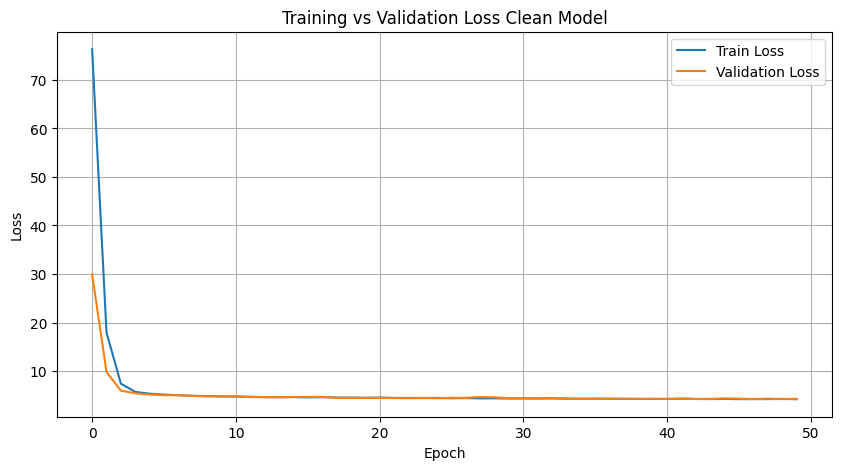

In [12]:
if SKIP_TRAINING == False:
    train_losses, val_losses = train_model(clean_model, criterion, optimizer)
    create_training_plot(train_losses, val_losses, "Clean Model")

In [13]:
class ModifiedAbaloneNetwork(nn.Module):
    def __init__(self):
        super(ModifiedAbaloneNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)  # Output layer for regression
        )

    def forward(self, x):
        return self.model(x)

In [14]:
modified_model = ModifiedAbaloneNetwork().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(modified_model.parameters(), lr=0.001)

Epoch 01 | Train Loss: 93.2313 | Val Loss: 82.3880 | MAE: 8.7041 | RMSE: 9.0768
Epoch 02 | Train Loss: 66.7769 | Val Loss: 58.8857 | MAE: 7.2625 | RMSE: 7.6737
Epoch 03 | Train Loss: 41.1779 | Val Loss: 32.0949 | MAE: 5.1757 | RMSE: 5.6652
Epoch 04 | Train Loss: 21.1507 | Val Loss: 13.5591 | MAE: 2.9904 | RMSE: 3.6823
Epoch 05 | Train Loss: 11.6355 | Val Loss: 7.7344 | MAE: 1.9985 | RMSE: 2.7811
Epoch 06 | Train Loss: 9.2446 | Val Loss: 5.6548 | MAE: 1.6078 | RMSE: 2.3780
Epoch 07 | Train Loss: 7.7602 | Val Loss: 5.2687 | MAE: 1.5682 | RMSE: 2.2954
Epoch 08 | Train Loss: 7.7168 | Val Loss: 5.1511 | MAE: 1.5144 | RMSE: 2.2696
Epoch 09 | Train Loss: 7.6368 | Val Loss: 5.2535 | MAE: 1.5171 | RMSE: 2.2921
No improvement in validation loss for 1 epoch(s).
Epoch 10 | Train Loss: 7.7598 | Val Loss: 5.2378 | MAE: 1.4997 | RMSE: 2.2886
No improvement in validation loss for 2 epoch(s).
Epoch 11 | Train Loss: 7.5728 | Val Loss: 4.9424 | MAE: 1.4977 | RMSE: 2.2232
Epoch 12 | Train Loss: 7.7831 | V

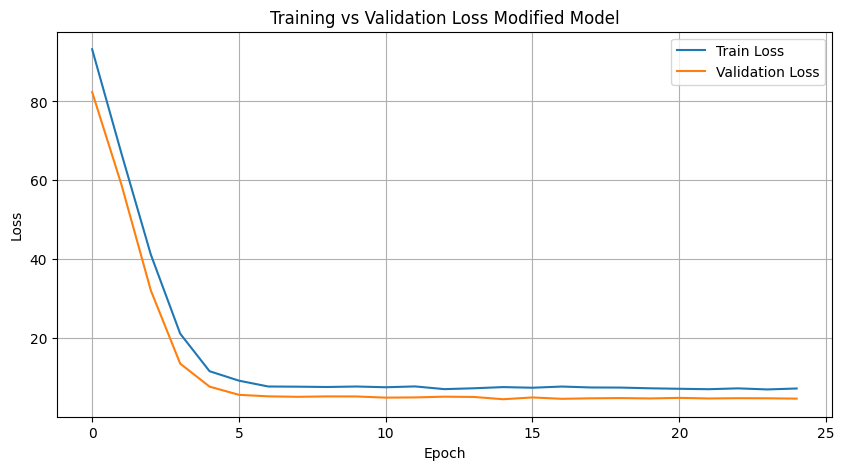

In [15]:
if SKIP_TRAINING == False:
    train_losses, val_losses = train_model(modified_model, criterion, optimizer)
    create_training_plot(train_losses, val_losses, "Modified Model")

In [16]:
# Load model
modified_model.load_state_dict(torch.load("best_model.pt"))
modified_model.eval()

# Predict
predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        outputs = modified_model(inputs)
        predictions.extend(outputs.cpu().numpy().flatten())

# Save to CSV
test_df = pd.read_csv("Data/test.csv")
test_df["Rings"] = predictions
test_df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv ✅")

Saved test_predictions.csv ✅
